# Importazione dati
Questo notebook verrà usato per l'importazione di tutti i database che ci servono \
I dati saranno salvati quindi nella cartella data\processed

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import json
from shapely.geometry import Point, Polygon

#Per usare multi cartelle (cookiecutter)
import sys
sys.path.append('./../src')

import make_dataset as m_d




## Grid data

In [2]:
#GRID
grid=m_d.safe_import("grid")

grid.plot('cellId')
grid

## Non da' problemi, poi dovrò mergiarlo

DriverError: ..\data\raw\trentino-grid.geojson: No such file or directory

# Social Pulse

In [3]:
#Questo fallisce ad importare, come mostrato a lezione 24

tweets_json = json.load( open(m_d.data_path_in / m_d.files['twitter'][0]) )

tweets = gpd.GeoDataFrame(tweets_json['features'])

#Creiamo il punto smontando la casella point
tweets['geometry'] = tweets['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
tweets.drop(columns=['geomPoint.geom'],inplace=True)

#Droppo roba inutile
tweets.drop(columns=['municipality.acheneID'],inplace=True)
tweets.drop(columns=['entities'],inplace=True)

tweets.plot("municipality.name")

#tweets.dtypes
tweets

FileNotFoundError: [Errno 2] No such file or directory: '..\\data\\raw\\social-pulse-trentino.geojson'

# Weather

In [5]:
"""
#Fallisce ad importare
weather=m_d.safe_import("weather")
weather
#Come prima ho metadati
"""
weather_json = json.load( open(m_d.data_path_in / m_d.files['weather'][0]) )
weather = gpd.GeoDataFrame(weather_json['features'])


#Elimino le colonne del vento (dati molto incompleti)
weather.drop(weather.columns[list(range(202,298))], axis=1, inplace=True)
weather.drop(columns=['minWind', "maxWind"], inplace=True)

#Svolgiamo infine i punti geometrici
weather['geometry'] = weather['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
weather.drop(columns=['geomPoint.geom'],inplace=True)

pd.set_option('display.max_columns', None)

#Lo salvo che mi serve in sezione ML
weather.to_csv(m_d.data_path_out / 'weather_final.csv',index=False)

weather.head(5)



FileNotFoundError: [Errno 2] No such file or directory: '..\\data\\raw\\meteotrentino-weather-station-data.json'

,station,elevation,geometry
0,T0071,905,POINT (10.79583 46.31340)
1,T0032,1155,POINT (11.25372 45.94027)
2,T0096,1205,POINT (11.66458 46.38364)
3,T0074,720,POINT (10.91841 46.35160)
4,T0101,201,POINT (11.07973 46.15635)


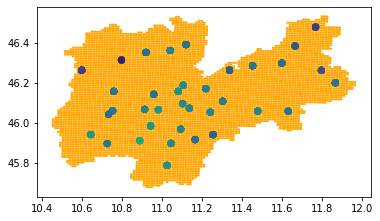

In [6]:
ax = grid.plot(color="orange")
weather.plot(column='maxTemperature',ax=ax)

#Visto che i tweets sono disassociati dalle stazioni, risulta necessario restringersi alla stazione più vicina
# -> Creo database delle stazioni
stations=m_d.orderstation(weather)


"""
Rimane un problema, le temperature non sono svolte
Spoiler: svolgerle è molto difficile (pandas ha davvero forte limitazioni sulle azioni che fa fare)
         le soluzioni sono molto non-pythoniche (o almeno quelle che ho trovato)
Idea migliore: creo una funzione (timesearch) che svolge il tempo per fare in modo che mi trovi temperatura e precipitazioni
"""
stations.head(5)

# Precipitazioni
Questa tabella è **probabilmente** più precisa di weather (fornisce per ogni elemento della griglia) -> darebbe precipitazione più precisa, ma mancano molte entries. Per ora usiamo solo quello del weather (anche perchè ho già scritto tutto con quel database) \
NOTA: per far questo basta un merge con DB tweets, ma devo ricalcolare il valore alle mezz'ore a causa di come ho discretizzato sotto

In [16]:
## Lascio qua la cella a puro scopo di chiarezza
"""
Questo si comporta bene
Non è utile importare i data availability tendenzialmente
La seconda colonna è il cellId, non viene detto ma si può verificare con il database grid
    suppongo la terza colonna sia intensità
"""

"""
dummy=m_d.safe_import('precip')
#Problema: il primo dato vien preso come dizionario
#Converto colonne
dummy=dummy.rename(columns={'201311010000': 'time', "2383": 'cellId', "1" : 'intensity'})

#Riaggiungo il primo dato
precipitation=m_d.appforth(dummy,[201311010000,2383,1])

#Converto il tempo per averlo in formato identico agli altri
temp=np.array(precipitation["time"])
#Questi sono integers, li svolgo in modo diverso
minutes=temp%100
temp=np.floor(temp/100)
precipitation["hours"]=np.around(temp%100+minutes/60,2)
temp=np.floor(temp/100)
precipitation["day"]=[int(i%100) for i in temp]
temp=np.floor(temp/100)
precipitation["month"]=[int(i%100) for i in temp]
precipitation.drop(columns=["time"], inplace=True)

precipitation
"""
""""""

''

# Electro

In [10]:
# devo prima unire i due dataset di line set -> nov e poi nov -> dicembre

#Problema: il primo dato vien preso come dizionario
electro = m_d.safe_import('SET-1')
electro=electro.rename(columns={'DG1000420': 'LINESET', "2013-11-01 00:00": 'Timestamp', "37.439999" : 'Value Amp'})
#Riaggiungo il primo dato
electro=m_d.appforth(electro,['DG1000420','2013-11-01 00:00',37.439999])

temp = m_d.safe_import('SET-2')
temp=temp.rename(columns={'DG1000420': 'LINESET', "2013-12-01 00:00": 'Timestamp', "36.719997" : 'Value Amp'})
#Riaggiungo il primo dato
temp=m_d.appforth(temp,['DG1000420','2013-12-01 00:00',36.719997])

electro=electro.append(temp, ignore_index=True)
del temp  #Pesa tanto

electro

SafeImport_Output:   Index(['DG1000420', '2013-11-01 00:00', '37.439999'], dtype='object')
SafeImport_Output:   Index(['DG1000420', '2013-12-01 00:00', '36.719997'], dtype='object')


,LINESET,Timestamp,Value Amp
0,DG1000420,2013-11-01 00:00,37.439999
1,DG1000420,2013-11-01 00:10,37.439999
2,DG1000420,2013-11-01 00:20,36.000000
3,DG1000420,2013-11-01 00:30,35.279999
4,DG1000420,2013-11-01 00:40,35.279999
...,...,...,...
1615889,DG1056626,2013-12-31 23:10,79.574997
1615890,DG1056626,2013-12-31 23:20,78.625000
1615891,DG1056626,2013-12-31 23:30,77.025002
1615892,DG1056626,2013-12-31 23:40,76.125000


In [11]:
#Unisco a dataframe che descrive posizioni sulla griglia
#Ne faccio un secondo che per alcune operazione è più comodo operare con l'altro
lines = m_d.safe_import('SET-lines')
electroLines = electro.merge(right=lines, how='outer')

#Ci sono incompatibilità tra i record salvati quindi li droppo cattivo
electroLines = electroLines.dropna()

electroLines

SafeImport_Output:   Index(['SQUAREID', 'LINESET', 'NR_UBICAZIONI'], dtype='object')


,LINESET,Timestamp,Value Amp,SQUAREID,NR_UBICAZIONI
0,DG1000420,2013-11-01 00:00,37.439999,4037,2
1,DG1000420,2013-11-01 00:00,37.439999,4154,13
2,DG1000420,2013-11-01 00:00,37.439999,4155,20
3,DG1000420,2013-11-01 00:00,37.439999,4156,2
4,DG1000420,2013-11-01 00:00,37.439999,4269,1
...,...,...,...,...,...
22227259,DG1056626,2013-12-31 23:50,75.775002,8502,1
22227260,DG1056626,2013-12-31 23:50,75.775002,8503,4
22227261,DG1056626,2013-12-31 23:50,75.775002,8621,1
22227262,DG1056626,2013-12-31 23:50,75.775002,8972,25


In [12]:
#Serve svolgere il timestamp
temp=list(electro["Timestamp"])
electro["month"]=[int(st[5:7]) for st in temp]
electro["day"]=[int(st[8:10]) for st in temp]
#electro["hours"]=[int(st[11:13])+int(st[14:16])/60 for st in temp]
electro["hours"]=[np.around(int(st[11:13])+int(st[14:16])/60, 2) for st in temp]
    #Round per safer groupby, albeit slower (should not matter, just print uniques)
    #Utile che fa anche un file più leggero
#print(electro.hours.unique())
    
electro.drop(columns=["Timestamp"], inplace=True)
electro.to_csv(m_d.data_path_out / 'electro_final.csv',index=False)
    #Lo salvo che mi serve altrove, e questo è lenta da eseguire

electro

,LINESET,Value Amp,month,day,hours
0,DG1000420,37.439999,11,1,0.00
1,DG1000420,37.439999,11,1,0.17
2,DG1000420,36.000000,11,1,0.33
3,DG1000420,35.279999,11,1,0.50
4,DG1000420,35.279999,11,1,0.67
...,...,...,...,...,...
1615889,DG1056626,79.574997,12,31,23.17
1615890,DG1056626,78.625000,12,31,23.33
1615891,DG1056626,77.025002,12,31,23.50
1615892,DG1056626,76.125000,12,31,23.67


# CIRCOSCRIZIONI

SafeImport_Output:   Index(['numero_cir', 'area', 'perimetro', 'nome', 'fumetto', 'geometry'], dtype='object')


,area,perimetro,nome,fumetto,geometry
0,8817959,14719,GARDOLO,Circoscrizione n. 1 - GARDOLO,"POLYGON ((663533.992 5108350.627, 663537.172 5..."
1,15712181,17850,MEANO,Circoscrizione n. 2 - MEANO,"POLYGON ((666651.786 5109264.902, 666650.353 5..."
2,36949609,38485,BONDONE,Circoscrizione n. 3 - BONDONE,"POLYGON ((660741.737 5109007.135, 660757.283 5..."
3,8663138,16403,SARDAGNA,Circoscrizione n. 4 - SARDAGNA,"POLYGON ((661627.540 5104968.137, 661632.747 5..."
4,16687779,27197,RAVINA-ROMAGNANO,Circoscrizione n. 5 - RAVINA-ROMAGNANO,"POLYGON ((663871.728 5094972.066, 663852.148 5..."
5,13199398,20575,ARGENTARIO,Circoscrizione n. 6 - ARGENTARIO,"POLYGON ((667907.213 5105334.453, 667905.638 5..."
6,15433274,18464,POVO,Circoscrizione n. 7 - POVO,"POLYGON ((669072.179 5099653.356, 668637.088 5..."
7,16409555,24413,MATTARELLO,Circoscrizione n. 8 - MATTARELLO,"POLYGON ((663871.728 5094972.066, 663875.878 5..."
8,7342864,15395,VILLAZZANO,Circoscrizione n. 9 - VILLAZZANO,"POLYGON ((666987.471 5098181.575, 666974.784 5..."
9,6962104,15418,OLTREFERSINA,Circoscrizione n. 10 - OLTREFERSINA,"POLYGON ((663813.095 5101039.248, 663813.095 5..."


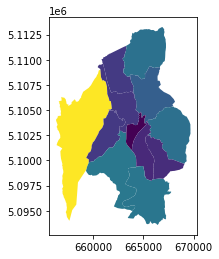

In [13]:
#Friendship ended with database del prof, database della provincia is now my best friend
circ=m_d.safe_import('circoscrizioni')

circ.plot("area")
circ=circ.sort_values("numero_cir").reset_index()
circ.drop(columns=["index", "numero_cir"], inplace=True)
circ

In [14]:
#Sistemo per riallacciare
circ.drop(columns=["fumetto", "area", "perimetro"],inplace=True)
circ.rename(columns={"nome" : "circoscrizione"}, inplace=True)

# Unione di Databases
Passo 1: creare un database dei tweets; a ogni tweet associo tempo atmosferico e temperatura \

Il tempo viene binnato in 30 minuti (mediamente abbiamo sui 20 tweets all'ora), visto che i dati sono ottenuti ogni 10 o 15 perderei informazioni ma per i tweets uso diretto il valore dalla tabella)

In [15]:
tweets=tweets.set_crs("EPSG:4326")
circ=circ.to_crs("EPSG:4326")
tweets = gpd.sjoin(tweets, grid, how="inner", op='intersects')
tweets.drop(columns="index_right", inplace=True)
tweets = gpd.sjoin(tweets, circ, how="left", op='intersects') 
    #Questi li attacco anche se potrei usare dirretto la grid, così è più comodo
tweets.drop(columns="index_right", inplace=True)
tweets


,created,timestamp,user,municipality.name,language,geometry,cellId,circoscrizione
0,2013-11-01T00:04:16,1383260656,5fd4f31f75,Trento,it,POINT (11.13000 46.07000),5201,S.GIUSEPPE-S.CHIARA
7,2013-11-01T01:25:10,1383265510,5fd4f31f75,Trento,it,POINT (11.13000 46.07000),5201,S.GIUSEPPE-S.CHIARA
8,2013-11-01T01:38:40,1383266320,5fd4f31f75,Trento,pt,POINT (11.13000 46.07000),5201,S.GIUSEPPE-S.CHIARA
131,2013-11-01T16:39:08,1383320348,020870293f,Trento,it,POINT (11.13000 46.07000),5201,S.GIUSEPPE-S.CHIARA
148,2013-11-01T17:25:31,1383323131,5fd4f31f75,Trento,it,POINT (11.13000 46.07000),5201,S.GIUSEPPE-S.CHIARA
...,...,...,...,...,...,...,...,...
27862,2013-12-31T22:41:18,1388526078,89a4654f90,Castello Tesino,it,POINT (11.65000 46.04000),5007,NaN
27855,2013-12-31T22:50:15,1388526615,89a4654f90,Castello Tesino,it,POINT (11.70000 46.05000),5128,NaN
27901,2013-12-31T23:57:45,1388530665,b12ff97cc9,Coredo,it,POINT (11.09000 46.34000),8707,NaN
27902,2013-12-31T23:57:32,1388530652,b12ff97cc9,Smarano,it,POINT (11.10000 46.34000),8708,NaN


In [16]:
#Visto che l'ora di tempo non è una quantità che correla a qualcosa di ciclico effettivamente misurabile*, ha poco senso
#separare ore e minuti ed quindi tanto vale trattarli insieme
#*Assumeremo eventi quali la campanella dei ragazzi delle superiori non influenzi in maniera importante i dati

###TEMPO DI ESECUZIONE QUALCHE MIN
from shapely.ops import nearest_points

Tw_final=pd.DataFrame()


N=len(tweets["created"])  #Numero tweets
temp=tweets["created"]
#TEMPO va smontato
Tw_final["month"]=[int(st[5:7]) for st in temp]
Tw_final["day"]=[int(st[8:10]) for st in temp]
Tw_final["hours"]=[int(st[11:13])+0.5*(int(st[14:16])>=30) for st in temp]

# TEMPERATURA E PRECIPITAZIONI
# per ricavare queste usiamo la stazione più vicina al tweet
# (sfortunamente il Trentino non ne ha tante, fortunatamente sono distribuite bene)
    
#Voglio farlo pythonico e rapido, quindi si userà nearest point
    #(ironicamente builtin sembra più lenta, si può ottimizzare ulteriormente)
#Vedi notebook note informative per una very very basic overview
nearest=[ stations[stations["geometry"]==nearest_points(gm,
            gpd.GeoSeries(stations["geometry"]).unary_union)[1]]["station"].values[0] for gm in tweets["geometry"]]
    #lista con nome della stazione più vicina

T=[]
R=[]
#Questo è ancora migliorabile come forma
for i in range(0,N):
    T.append(m_d.find_Weather(weather, Tw_final.loc[i]["month"],
                                Tw_final.loc[i]["day"], Tw_final.loc[i]["hours"], nearest[i], varType=0))
    R.append(m_d.find_Weather(weather, Tw_final.loc[i]["month"],
                                Tw_final.loc[i]["day"], Tw_final.loc[i]["hours"], nearest[i], varType=1))
Tw_final["temperature"]=T
Tw_final["rain"]=R


#Il resto lo importo direttamente
Tw_final["municipal"]=tweets["municipality.name"]
Tw_final["cellId"]=tweets["cellId"]
Tw_final["language"]=tweets["language"]
Tw_final["circoscrizione"]=tweets["circoscrizione"]

#Salviamo infine il database
Tw_final.to_csv(m_d.data_path_out / 'twitter_final.csv',index=False)

############MANCA ELETTRICITA' A QUESTO FILE (SE VOGLIO FARE EDA Ntw vs Elett)!!!!!!!!!!!

Tw_final

,month,day,hours,temperature,rain,municipal,cellId,language,circoscrizione
0,11,1,0.0,13.2,0.0,Trento,5201,it,S.GIUSEPPE-S.CHIARA
1,11,1,1.0,12.9,0.0,Pinzolo,7167,tl,NaN
2,11,1,1.5,12.4,0.0,Cavalese,8151,en,NaN
3,11,1,16.5,14.8,0.0,Rovereto,2855,it,NaN
4,11,1,17.0,14.4,0.0,San Michele all'Adige,6838,ru,NaN
...,...,...,...,...,...,...,...,...,...
27936,12,31,22.5,-3.4,0.0,Vigo di Fassa,9922,it,NaN
27937,12,31,22.5,-3.4,0.0,Predazzo,8513,it,NaN
27938,12,31,23.5,-5.1,0.0,Sant'Orsola Terme,5799,it,NaN
27939,12,31,23.5,-4.5,0.0,Sant'Orsola Terme,5799,it,NaN


In [22]:
#Roba che è meglio checckare
#Tw_final[Tw_final["temperature"].isnull()]  #Pochi tweets senza valore, poco male
Tw_final[Tw_final["circoscrizione"].isnull()]  #8000 tweets a trento, ok


,month,day,hours,temperature,rain,municipal,cellId,language,circoscrizione
1,11,1,1.0,12.9,0.0,Pinzolo,7167,tl,NaN
2,11,1,1.5,12.4,0.0,Cavalese,8151,en,NaN
3,11,1,16.5,14.8,0.0,Rovereto,2855,it,NaN
4,11,1,17.0,14.4,0.0,San Michele all'Adige,6838,ru,NaN
6,11,2,13.5,14.5,0.0,Rovereto,2854,und,NaN
...,...,...,...,...,...,...,...,...,...
27936,12,31,22.5,-3.4,0.0,Vigo di Fassa,9922,it,NaN
27937,12,31,22.5,-3.4,0.0,Predazzo,8513,it,NaN
27938,12,31,23.5,-5.1,0.0,Sant'Orsola Terme,5799,it,NaN
27939,12,31,23.5,-4.5,0.0,Sant'Orsola Terme,5799,it,NaN


In [ ]:
#Aggiungiamo anche il consumo elettrico associato al tweet
    #prob overkill per l'EDA ma dovrei saperlo fare in fretta ormai 
#Tw_final=pd.read_csv(m_d.data_path_out / "twitter_final.csv")

#ElectroLines.groupby("SQUAREID")


# Machine learning
Voglio creare un database su cui operare di machine learning \
Uso database salvati con appropriate assunzioni \
Lo faccio in funzione che è molto lunga e non ha c'è molto da presentare \
Vedi meglio in sezione ML \

In [3]:
regressdB=m_d.df_reg()
regressdB.to_csv(m_d.data_path_out / 'MachineLearningDB.csv',index=False)

regressdB.head(5)